In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pickle
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from scipy import stats
from tqdm import tqdm
# from skbio.stats.composition import clr
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(device)

from utils import *

# later could use comet_ml for hyperparam optm
# import comet_ml
# API_KEY=
# experiment = Experiment(
#     api_key=API_KEY,
#     project_name="",
#     workspace="",
# )

cuda:0


### Create datasets

In [1]:
## preprocess this subset of data
p_data, n_data = "data/orig_species_10k.pkl", ""
data_df = pickle.load(open(p_data, "rb"))
idx, data_df = data_df.iloc[:, :1], data_df.iloc[:, 1:]

# remove emtpy samples first
idx = idx.loc[data_df.sum(axis=1) >= 0]
data_df = data_df.loc[data_df.sum(axis=1) >= 0]
'''
remove the samples w/ low total abundance. 
I checked that total abundance ~lognormal; remove the <-2sigma (~5%) lowest samples. 
'''
lower_bound = np.exp(np.mean(np.log(data_df.sum(axis=1)))-2*np.std(np.log(data_df.sum(axis=1))))
idx = idx.loc[data_df.sum(axis=1) >= lower_bound]
data_df = data_df.loc[data_df.sum(axis=1) >= lower_bound]

## remove the rare species (present in <5% samples)
n_samples = data_df.shape[0]
data_df = data_df.loc[:, (data_df>0).sum(axis=0) >= 0.05*n_samples]

## normalize to relative abundance
data_df = data_df.div(data_df.sum(axis=1), axis=0)
# data_df = pd.concat([idx, data_df], axis=1)

## separate train and test
features = (data_df>0).values.astype(float)
labels = data_df.values
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## clr transformation for outputs
zero_thr = 1e-8
gmean_train = (np.exp(np.nansum(np.log(y_train[y_train > 0]+zero_thr)) / np.size(y_train)))
y_train_clr = np.log((y_train+zero_thr)/gmean_train)
y_test_clr = np.log((y_test+zero_thr)/gmean_train)

## rescale the data
scaler = preprocessing.MaxAbsScaler().fit(y_train_clr)
# scaler = preprocessing.RobustScaler().fit(y_train_clr)
y_train_scaled = scaler.transform(y_train_clr)
y_test_scaled = scaler.transform(y_test_clr)

## transform to tensors
X_train_scaled=torch.from_numpy(X_train).float()
y_train_scaled=torch.from_numpy(y_train_scaled).float()
X_test_scaled=torch.from_numpy(X_test).float()
y_test_scaled=torch.from_numpy(y_test_scaled).float()

## make dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels, device=None):
        self.labels = labels
        self.features = features
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.features[idx]
        return {"Features": data, "Labels": label}
    
Train = CustomDataset(X_train_scaled, y_train_scaled)
Test = CustomDataset(X_test_scaled, y_test_scaled)

## create batch spits of data
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=True, **kwargs)
test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=True, **kwargs)

NameError: name 'pickle' is not defined

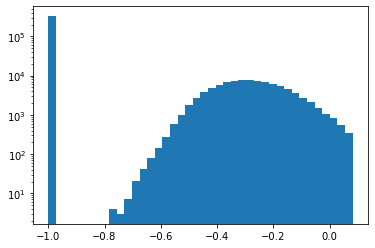

In [14]:
plt.hist(y_test_scaled.numpy().flatten(), bins=40)
plt.yscale("log")

In [15]:
features.shape

(9670, 217)

### Implement VAE

In [16]:
def compute_loss(model, features, labels, weights):
    recon_x, mu, logvar = model(features)
    recon_loss = F.mse_loss(recon_x, labels, reduction="sum")
    '''
    new recon_loss: if 
    '''
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = weights[0]*recon_loss + weights[1]*kl_loss
    return recon_x, loss, weights[0]*recon_loss, weights[1]*kl_loss

def gaussian_nll(y_true, mu, logvar, mask):
    # mask: same shape as y_true, 1 for valid, 0 for -1 positions
    # add eps for numerical stability
    var = torch.exp(logvar) + 1e-6
    nll = 0.5 * (logvar + (y_true - mu)**2 / var)
    return torch.sum(nll * mask)

def compute_loss_2(model, features, labels, weights):
    b, nb, mu, logvar = model(features)
    mask = (labels!=-1).float()
    
    bce_loss = F.binary_cross_entropy(b, mask, reduction='sum')
    recon_loss = torch.sum(F.mse_loss(nb, labels, reduction="none") * mask)

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = weights[0]*recon_loss + weights[1]*bce_loss + weights[2]*kl_loss
    return b, nb, loss, weights[0]*recon_loss, weights[1]*bce_loss, weights[2]*kl_loss

In [17]:
class VAETrainer:
    def __init__(self, model, train_loader, test_loader, optimizer, weights, device="cuda:0"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.weights = weights
        self.device = device

    def train_one_epoch(self, zero_thr):
        self.model.train()
        total_loss, total_recon_loss, total_bce_loss, total_kl_loss = 0, 0, 0, 0
        total_acc = 0
        total_len = 0
        for batch in self.train_loader:
            batch['Features'], batch['Labels'] = batch['Features'].to(device), batch['Labels'].to(device)
            
            self.optimizer.zero_grad()
#             recon_x, loss, recon_loss, kl_loss = compute_loss(self.model, batch['Features'], batch['Labels'], self.weights)
            b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(self.model, batch['Features'], batch['Labels'], self.weights)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_bce_loss += bce_loss.item()
            total_kl_loss += kl_loss.item()
            
#             out = ((recon_x.detach())>zero_thr).float()
            out = (b.detach()>0.5).float()
            total_acc += (out == batch['Features']).float().sum().item() # for binary-abundance
            total_len += batch["Features"].shape[0]

        return total_loss / total_len, \
               total_recon_loss / total_len, \
               total_bce_loss / total_len, \
               total_kl_loss / total_len, \
               total_acc / total_len / batch["Features"].shape[1]

    @torch.no_grad()
    def test_one_epoch(self, zero_thr):
        self.model.eval()
        total_loss, total_recon_loss, total_bce_loss, total_kl_loss = 0, 0, 0, 0
        total_acc = 0
        total_len = 0
        for batch in self.test_loader:
            batch['Features'], batch['Labels'] = batch['Features'].to(device), batch['Labels'].to(device)
            
#             recon_x, loss, recon_loss, kl_loss = compute_loss(self.model, batch['Features'], batch['Labels'], self.weights)
            b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(self.model, batch['Features'], batch['Labels'], self.weights)
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_bce_loss += bce_loss.item()
            total_kl_loss += kl_loss.item()
            
#             out = ((recon_x.detach())>zero_thr).float()
            out = (b.detach()>0.5).float()
            total_acc += (out == batch['Features']).float().sum().item() # for binary-abundance
            total_len += batch["Features"].shape[0]

        return total_loss / total_len, \
               total_recon_loss / total_len, \
               total_bce_loss / total_len, \
               total_kl_loss / total_len, \
               total_acc / total_len / batch["Features"].shape[1]

In [18]:
input_dim = X_test.shape[1] 
hidden_dim = 2048
latent_dim = 100
epochs = 100
lr = 1e-3
weight_decay = 1e-4
zero_thr = -0.8
weights = [1.0, 1.0, 0.0]

model = VAE_2(input_dim, latent_dim, hidden_dim).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=lr,
    weight_decay=weight_decay
)

trainer = VAETrainer(model, train_DS, test_DS, optimizer, weights, device)

train_losses = []
test_losses = []
train_acc = []
test_acc = []
MSEs, BCEs, KLDs = [], [], []
for epoch in tqdm(range(epochs)):
#     recon_x, train_loss, MSE, KLD, acc = trainer.train_one_epoch(zero_thr)
    train_loss, MSE, BCE, KLD, acc = trainer.train_one_epoch(zero_thr)
    train_losses.append(train_loss)
    train_acc.append(acc)
    MSEs.append(MSE)
    BCEs.append(BCE)
    KLDs.append(KLD)
    
#     recon_x, test_loss, MSE, KLD, acc = trainer.test_one_epoch(zero_thr)
    test_loss, MSE, BCE, KLD, acc = trainer.test_one_epoch(zero_thr)
    test_losses.append(test_loss)
    test_acc.append(acc)

100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


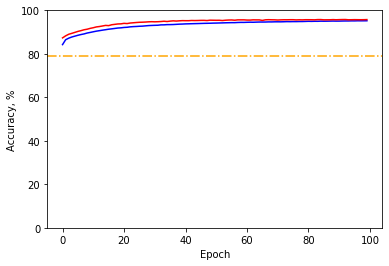

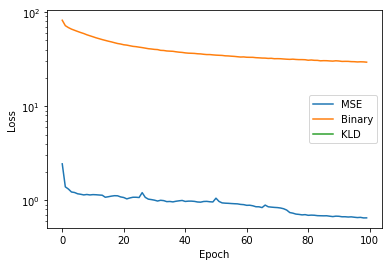

In [19]:
# training 
train_acc=np.array(train_acc)
test_acc = np.array(test_acc)
plt.plot(range(train_acc.shape[0]), train_acc*100, c='blue', label = "train_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy, %")
plt.ylim([0, 100])
#     plt.xlim([0,1000])  # adjust the right leaving left unchanged
plt.plot(range(test_acc.shape[0]), test_acc*100, c='red', label = "test_acc")
prevalence=np.sum(X_train_scaled.numpy(), axis=0)/X_train.shape[0]
prevalence[prevalence>=0.5]=1
prevalence[prevalence<0.5]=0
# horizontal line showing dumb predictions based on prevalence
acc=(1-np.sum(np.abs(X_test_scaled.numpy()-prevalence))/X_test_scaled.shape[0]/prevalence.shape[0])*100
plt.axhline(y = acc, color = 'orange', linestyle = '-.')

# train_losses=np.array(train_losses)
# test_losses=np.array(test_losses)
# plt.plot(range(train_acc.shape[0]), train_losses*100/np.max(train_losses), c='blue', label = "train_loss", ls='--')
# plt.plot(range(train_acc.shape[0]), test_losses*100/np.max(train_losses), c='red', label = "test_loss", ls='--')
# plt.legend(frameon=False)
plt.show()

# show the losses
lists = [MSEs, BCEs, KLDs]
names = ["MSE", "Binary", "KLD"]
for (yloss, loss_name) in zip(lists, names):
    plt.plot(range(train_acc.shape[0]), yloss, label=loss_name)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

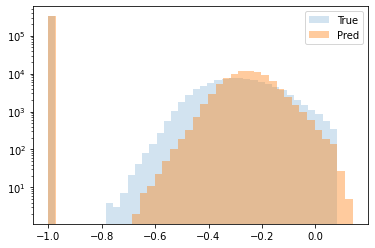

(419678,) 412300


In [20]:
# compare initial and reconstructed features
plt.hist(y_test_scaled.numpy().flatten(), bins=40, alpha=0.2, label="True")
all_recon = []
for batch in test_DS:
#     recon_x, loss, recon_loss, kl_loss = compute_loss(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
#     recon_x = recon_x.detach().cpu().numpy().flatten()
#     recon_x[recon_x<zero_thr] = -1
    b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
    recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
    recon_x = recon_x.detach().cpu().numpy().flatten()
    all_recon.extend(list(recon_x))
plt.hist(all_recon, bins=40, alpha=0.4, label="Pred")
plt.yscale("log")
plt.legend()
plt.show()

print(y_test_scaled.numpy().flatten().shape, len(all_recon))

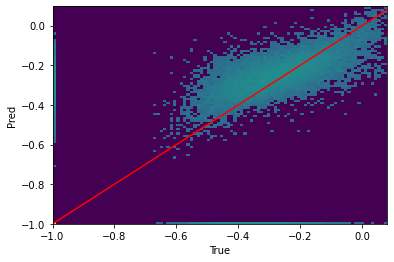

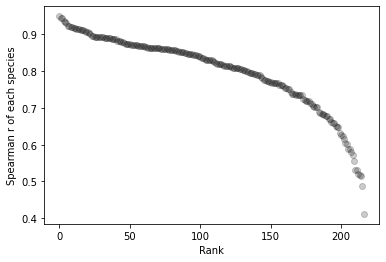

0.9495980397640431 Bacteria.Bacillota.Bacilli.Lactobacillales.Streptococcaceae.Lactococcus
0.9454710509504466 Bacteria.Pseudomonadota.Gammaproteobacteria.Pseudomonadales.Moraxellaceae.Acinetobacter
0.9454082193295412 Bacteria.Bacteroidota.Bacteroidia.Bacteroidales.Prevotellaceae.Segatella
0.9379155470783965 Bacteria.NA.NA.NA.NA.NA
0.9346147196021508 Bacteria.Fusobacteriota.Fusobacteriia.Fusobacteriales.Fusobacteriaceae.Fusobacterium
0.9323477825831391 Bacteria.Bacillota.Bacilli.Erysipelotrichales.Erysipelotrichaceae.[Clostridium] innocuum group
0.923990166597437 Bacteria.Bacillota.Clostridia.Lachnospirales.Lachnospiraceae.[Ruminococcus] gnavus group
0.9219506148398319 Bacteria.Verrucomicrobiota.Verrucomicrobiia.Verrucomicrobiales.Akkermansiaceae.Akkermansia
0.9195057889336042 Bacteria.Pseudomonadota.Gammaproteobacteria.Enterobacterales.Enterobacteriaceae.NA
0.9192665273861372 Bacteria.Bacillota.Clostridia.Oscillospirales.Oscillospiraceae.UCG-002
0.917003616204486 Bacteria.Bacillota.Clo

Text(0, 0.5, 'Spearman r')

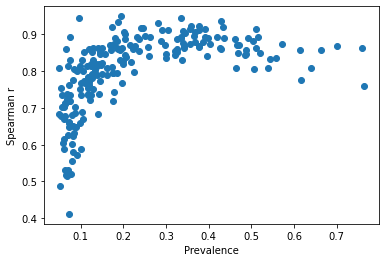

In [22]:
# check the reconstruction values
true_x_list = []
recon_x_list = []
n_batch_use = 2

for (idx, batch) in enumerate(test_DS):
    true_x = batch['Labels'].detach().numpy()
#     recon_x, u, logvar = model(batch['Features'].to(device))
#     recon_x = recon_x.detach().cpu().numpy()
    b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
    recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
    recon_x = recon_x.detach().cpu().numpy()
    true_x_list.append(true_x)
    recon_x_list.append(recon_x)
    if(idx>=n_batch_use):
        break
        
true_x_list = np.vstack(true_x_list)
recon_x_list = np.vstack(recon_x_list)
plt.hist2d(x=true_x_list.flatten(), y=recon_x_list.flatten(), norm=matplotlib.colors.PowerNorm(1/10), cmap='viridis', bins=100)
plt.plot([-1.0, 0.2], [-1.0, 0.2], color="r")
plt.xlabel("True")
plt.ylabel("Pred")
plt.show()

# spearman r by species
coeffs = [ stats.spearmanr(true_x_list[:, i], recon_x_list[:, i]) for i in range(true_x_list.shape[1]) ]
coeffs_sorted = sorted(enumerate(coeffs), key=lambda x: x[1], reverse=True)
plt.scatter(range(len(coeffs)), [val[0] for (idx, val) in coeffs_sorted], color="k", alpha=0.2)
plt.xlabel("Rank")
plt.ylabel("Spearman r of each species")
plt.show()

# top x best predicted species
for i in range(20):
    print(coeffs_sorted[i][1][0], data_df.columns[coeffs_sorted[i][0]])
    
# predictibility vs prevalence
plt.scatter([np.sum(data_df.values[:, i]>0)/data_df.values.shape[0] for i in range(data_df.shape[1])], \
             [i[0] for i in coeffs])
plt.xlabel("Prevalence")
plt.ylabel("Spearman r")

In [57]:
np.sum(data_df.values[:, 0]>0)/data_df.values.shape[0]

0.43660806618407444

In [52]:
batch["Features"].shape[0]

NameError: name 'batch' is not defined

In [10]:
p_data, n_data = "data/orig_species_10k.pkl", ""
data_df_1 = pickle.load(open(p_data, "rb"))

spcs = list(data_df_1.columns)
for spc in spcs:
    if("Akkermansia" in spc):
        print(spc)

Bacteria.Verrucomicrobiota.Verrucomicrobiia.Verrucomicrobiales.Akkermansiaceae.Akkermansia


In [11]:
spcs[:10]

['sample',
 'Bacteria.Actinomycetota.Coriobacteriia.Coriobacteriales.Atopobiaceae.Tractidigestivibacter',
 'Bacteria.Actinomycetota.Coriobacteriia.Coriobacteriales.Coriobacteriaceae.Collinsella',
 'Bacteria.Actinomycetota.Coriobacteriia.Coriobacteriales.Eggerthellaceae.Adlercreutzia',
 'Bacteria.Actinomycetota.Coriobacteriia.Coriobacteriales.Eggerthellaceae.Senegalimassilia',
 'Bacteria.Bacillota.Bacilli.Erysipelotrichales.Erysipelotrichaceae.Holdemanella',
 'Bacteria.Bacillota.Bacilli.Erysipelotrichales.Erysipelotrichaceae.NA',
 'Bacteria.Bacillota.Bacilli.Lactobacillales.Lactobacillaceae.Lactiplantibacillus',
 'Bacteria.Bacillota.Bacilli.Lactobacillales.Lactobacillaceae.Limosilactobacillus',
 'Bacteria.Bacillota.Bacilli.Lactobacillales.Lactobacillaceae.Pediococcus']